# Setup

In [6]:
import pandas as pd
import optuna
import xgboost as xgb

In [7]:
import os, sys
CURRENT_DIR = os.path.dirname(os.path.abspath('.'))
sys.path.append(os.path.dirname(CURRENT_DIR+"/metrics.py"))

from metrics import CalcMetrics

get_metric = CalcMetrics()

Importando os datasets de treino, validação e teste

In [8]:
train = pd.read_csv('../datasets/processed/train.csv')
X_train, y_train = train.drop(['satisfaction'], axis=1), train['satisfaction']
dtrain = xgb.DMatrix(X_train, label=y_train)

validation = pd.read_csv('../datasets/processed/validation.csv')
X_validation, y_validation = validation.drop(['satisfaction'], axis=1), validation['satisfaction']
dvalidation = xgb.DMatrix(X_validation, label=y_validation)

test = pd.read_csv('../datasets/processed/test.csv')
X_test, y_test = test.drop(['satisfaction'], axis=1), test['satisfaction']
dtest = xgb.DMatrix(X_test, label=y_test)

# Modelo básico

In [19]:
params = {
    'max_depth': 3,
    'eta': 0.1,
    'objective': 'binary:logistic'
}

# Train the model
num_round = 100
bst = xgb.train(params, dtrain, num_round)

In [20]:
y_pred = bst.predict(dtest)

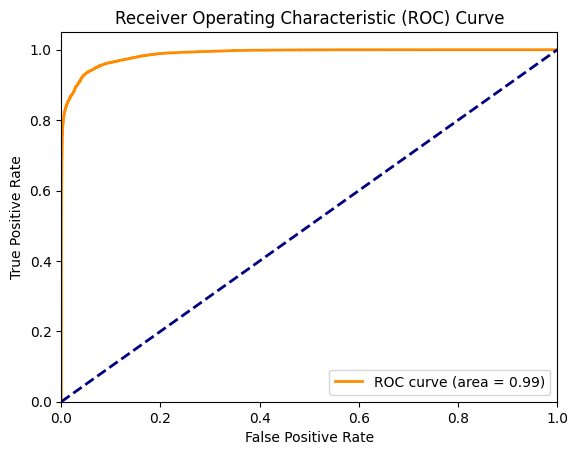

In [22]:
get_metric.auc(y_pred, y_test)

In [23]:
get_metric.ks(y_pred, y_test)

np.float64(0.884089631542823)

# Teste inicial utilizando o Optuna

In [31]:
def objective(trial):
    # Define the parameter search space
    params = {
        'objective': 'binary:logistic',
        'learning_rate': trial.suggest_float('learning_rate', 1e-4, 1e-1),
        'n_estimators': trial.suggest_int('n_estimators', 50, 1000),
        'subsample': trial.suggest_float('subsample', 0.1, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 20),
        'max_depth': trial.suggest_int('max_depth', 2, 20),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1, 1.0)
    }

    bst = xgb.train(params, dtrain, num_boost_round=params['n_estimators'])

    # Make predictions and evaluate the model
    preds = bst.predict(dtest)
    
    ks = get_metric.ks(preds, y_test)

    return ks

In [32]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

# Print the best hyperparameters
print("Best hyperparameters: ", study.best_params)
print("Best value: ", study.best_value)

[I 2024-07-23 09:05:42,116] A new study created in memory with name: no-name-6d43bdd1-2ed6-4e7c-b5b5-d000ef89a845
/home/ronald/.local/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [09:05:42] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2024-07-23 09:05:42,817] Trial 0 finished with value: 0.8943800154341256 and parameters: {'learning_rate': 0.05299296835705285, 'n_estimators': 70, 'subsample': 0.15034715652811878, 'min_child_weight': 15, 'max_depth': 10, 'gamma': 2.745639226529273, 'colsample_bytree': 0.9942713073754869}. Best is trial 0 with value: 0.8943800154341256.
/home/ronald/.local/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [09:05:42] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2024-07-23 09:05:45,843] Trial 1 finished with value: 0.9140790309094063 and parameters: {'learning_rate': 0

Best hyperparameters:  {'learning_rate': 0.09385796484013235, 'n_estimators': 976, 'subsample': 0.8647494152550593, 'min_child_weight': 1, 'max_depth': 14, 'gamma': 3.443781277581112, 'colsample_bytree': 0.8436833949649735}
Best value:  0.9257939834230734


In [33]:
bst = xgb.train(study.best_params, dtrain, num_boost_round=study.best_params['n_estimators'])

/home/ronald/.local/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [09:20:38] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


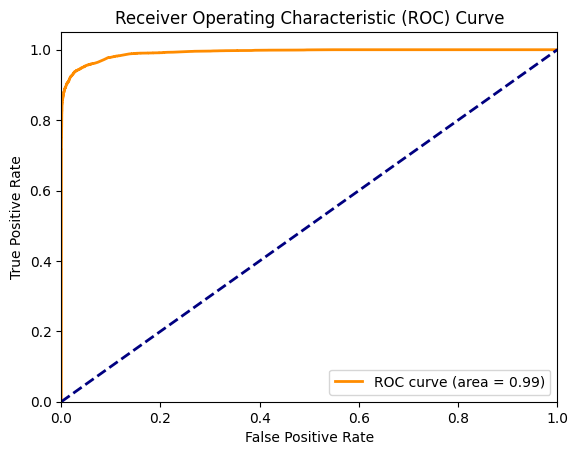

In [35]:
y_pred = bst.predict(dtest)

get_metric.auc(y_pred, y_test)